Empirical question
4. a).

In [1]:
import scipy.interpolate
import pandas as pd
from pandas import *
import scipy.optimize as optimize
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import numpy as np
from numpy import linalg as LA

In [2]:
# read the data file. I have attached the excel file in the repository.
xls = pd.ExcelFile('/Users/apple/Desktop/data for APM466 AS1.xlsx')
df1 = pd.read_excel(xls, '1.2')
df2 = pd.read_excel(xls, '1.3')
df3 = pd.read_excel(xls, '1.6')
df4 = pd.read_excel(xls, '1.7')
df5 = pd.read_excel(xls, '1.8')
df6 = pd.read_excel(xls, '1.9')
df7 = pd.read_excel(xls, '1.10')
df8 = pd.read_excel(xls, '1.13')
df9 = pd.read_excel(xls, '1.14')
df10 = pd.read_excel(xls, '1.15')
df = [df1,df2,df3,df4,df5,df6,df7,df8,df9,df10]

In [3]:
# calculation of half year time to maturity.
def ttm(x):
    current_date = list(x.columns.values)[0]
    x['time to maturity'] = [(maturity - current_date).days for maturity in x['maturity date']]

In [4]:
# calculation of yield to maturity.
def ytm(x):
    tr, yr = [], []
    current_date = list(x.columns.values)[0]
    for i, bond in x.iterrows():
        ttm = bond['time to maturity']
        tr.append(ttm/365)
        
        # separate the time to maturity to small time interval.
        y = int(ttm/182)
        init = (ttm%182)/365
        time = np.asarray([2 * init + n for n in range(0,y+1)])

        # convert the clean close price to dirty price.
        coupon = bond['coupon']*100
        accrued_interest = coupon * ((182-ttm%182)/365)
        dirty_price = bond['close price'] + accrued_interest
        
        # make each payments in different time period as an array.
        pmt = np.asarray([coupon/2] * y + [coupon/2 + 100])
        
        # use optimization to solve the yield to maturity.
        ytm_func = lambda y: np.dot(pmt, (1+y/2) ** (-time)) - dirty_price
        ytm = optimize.fsolve(ytm_func, .05)
        yr.append(ytm)
    return tr,yr

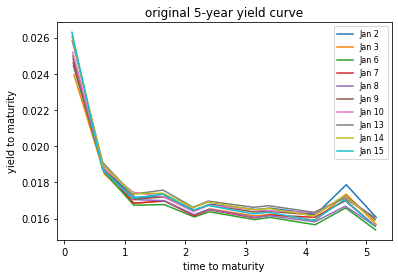

In [5]:
# plot the yield curve:
labels = ['Jan 2','Jan 3','Jan 6','Jan 7','Jan 8',
         'Jan 9','Jan 10','Jan 13','Jan 14','Jan 15']
plt.xlabel('time to maturity')
plt.ylabel('yield to maturity')
plt.title('original 5-year yield curve')
i = 0
for d in df:
    ttm(d)
    plt.plot(ytm(d)[0], ytm(d)[1], label = labels[i])
    i = i+1
plt.legend(loc = 'upper right', prop={"size":8})

In [6]:
# interpolation.
def ip(tr, yr):
    t = [0.5,1,1.5,2,2.5,3,3.5,4,4.5,5]
    y = []
    interp = scipy.interpolate.interp1d(tr, yr, bounds_error=False)
    for i in t:
        value = float(interp(i))
        if not scipy.isnan(value):
            y.append(value)
    return t,y

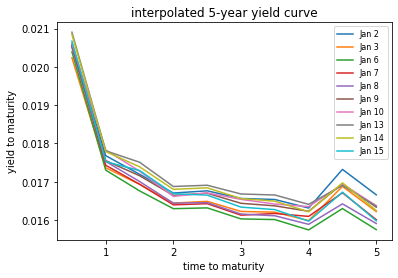

In [7]:
# plot the interpolated yield curve:
labels = ['Jan 2','Jan 3','Jan 6','Jan 7','Jan 8',
         'Jan 9','Jan 10','Jan 13','Jan 14','Jan 15']
plt.xlabel('time to maturity')
plt.ylabel('yield to maturity')
plt.title('interpolated 5-year yield curve')
i = 0
for d in df:
    ttm(d)
    result = ytm(d)
    a = np.asarray(result[0])
    b = np.asarray(result[1]).squeeze()
    y = ip(a,b)
    plt.plot(y[0], y[1], label = labels[i])
    i = i+1
plt.legend(loc = 'upper right', prop={"size":8})

b).

In [8]:
# bootstrapping and calculate the spot rate:
def spot(x):
    s = np.empty([1,11])
    tr = []
    coupons = []
    dirty_price = []
    for i, bond in x.iterrows():
        ttm = bond['time to maturity']
        tr.append(ttm/365)
        coupon = bond['coupon']*100
        coupons.append(coupon)
        accrued_interest = coupon * (0.5 - (ttm % 182)/365)
        dirty_price.append(bond['close price'] + accrued_interest)
        
    for i in range(0,11):
        if i == 0:
            # 0 <= T <= 0.5:
            s[0, i] = -np.log(dirty_price[i]/(coupons[i]/2+100))/tr[i]
        else:
            # 0.5 <= T <= 1:
            pmt = np.asarray([coupons[i]/2] * i + [coupons[i]/2 + 100])
            spot_func = lambda y: np.dot(pmt[:-1], 
                        np.exp(-(np.multiply(s[0,:i], tr[:i])))) + pmt[i] * np.exp(-y * tr[i]) - dirty_price[i]      
            s[0, i] = optimize.fsolve(spot_func, .05)
    s[0, 5] = (s[0, 4] + s[0, 6])/2
    s[0, 7] = (s[0, 5] + s[0, 8])/2
    return tr, s

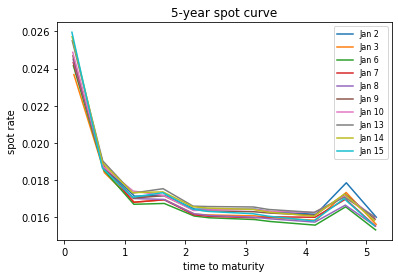

In [9]:
# plot the spot curve:
labels = ['Jan 2','Jan 3','Jan 6','Jan 7','Jan 8',
         'Jan 9','Jan 10','Jan 13','Jan 14','Jan 15']
plt.xlabel('time to maturity')
plt.ylabel('spot rate')
plt.title('5-year spot curve')
i = 0
for d in df:
    ttm(d)
    plt.plot(spot(d)[0], spot(d)[1].squeeze(), label = labels[i])
    i = i+1
plt.legend(loc = 'upper right', prop={"size":8})

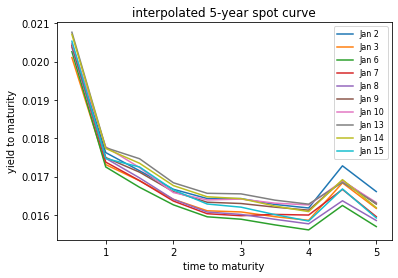

In [10]:
# spot rate after interpolation:
labels = ['Jan 2','Jan 3','Jan 6','Jan 7','Jan 8',
         'Jan 9','Jan 10','Jan 13','Jan 14','Jan 15']
plt.xlabel('time to maturity')
plt.ylabel('yield to maturity')
plt.title('interpolated 5-year spot curve')
i = 0
for d in df:
    ttm(d)
    result = spot(d)
    a = np.asarray(result[0])
    b = np.asarray(result[1]).squeeze()
    y = ip(a,b)
    plt.plot(y[0], y[1], label = labels[i])
    i = i+1
plt.legend(loc = 'upper right', prop={"size":8})

c).

In [11]:
# the forward curve:
def forward(x):
    ttm(d)
    result = spot(d)
    a = np.asarray(result[0])
    b = np.asarray(result[1]).squeeze()
    y = ip(a,b)
    f1 = (y[1][3] * 2 - y[1][1] * 1)/(2-1)
    f2 = (y[1][5] * 3 - y[1][1] * 1)/(3-1)
    f3 = (y[1][7] * 4 - y[1][1] * 1)/(4-1)
    f4 = (y[1][9] * 5 - y[1][1] * 1)/(5-1)
    f = [f1,f2,f3,f4]
    return f

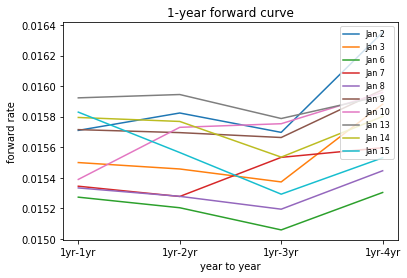

In [12]:
# plot the forward curve:
labels = ['Jan 2','Jan 3','Jan 6','Jan 7','Jan 8',
         'Jan 9','Jan 10','Jan 13','Jan 14','Jan 15']
plt.xlabel('year to year')
plt.ylabel('forward rate')
plt.title('1-year forward curve')
i = 0
f_m = np.empty([4,10])
for d in df:
    ttm(d)
    plt.plot(['1yr-1yr','1yr-2yr','1yr-3yr','1yr-4yr'], forward(d), label = labels[i])
    f_m[:,i] = forward(d)
    i = i+1
plt.legend(loc = 'upper right', prop={"size":8})

5.

In [13]:
# the calculation of log returns matrix of yield.
log = np.empty([5,9])
yi = np.empty([5,10])
for i in range(len(df)):
    ttm(df[i])
    result = ytm(df[i])
    a = np.asarray(result[0])
    b = np.asarray(result[1]).squeeze()
    y = ip(a,b) 
    yi[0,i] = y[1][1]
    yi[1,i] = y[1][3]
    yi[2,i] = y[1][5]
    yi[3,i] = y[1][7]
    yi[4,i] = y[1][9]
    
for i in range(0, 9):
    log[0, i] = np.log(yi[0,i+1]/yi[0,i])
    log[1, i] = np.log(yi[1,i+1]/yi[1,i])
    log[2, i] = np.log(yi[2,i+1]/yi[2,i])
    log[3, i] = np.log(yi[3,i+1]/yi[3,i])
    log[4, i] = np.log(yi[4,i+1]/yi[4,i])
    
       
# calculation of the covariance matrix.
np.cov(log)   

array([[1.10832346e-04, 5.72306569e-05, 9.68850363e-05, 1.08383233e-04,
        1.19596891e-04],
       [5.72306569e-05, 1.03644186e-04, 1.16628470e-04, 1.27058879e-04,
        1.51295888e-04],
       [9.68850363e-05, 1.16628470e-04, 1.54610492e-04, 1.77325258e-04,
        2.08875836e-04],
       [1.08383233e-04, 1.27058879e-04, 1.77325258e-04, 2.68503621e-04,
        2.81387104e-04],
       [1.19596891e-04, 1.51295888e-04, 2.08875836e-04, 2.81387104e-04,
        3.40667751e-04]])

In [14]:
# calculation of the covariance matrix.
np.cov(f_m)

array([[5.71800411e-08, 5.01813988e-08, 2.96841323e-08, 3.63194051e-08],
       [5.01813988e-08, 6.70020150e-08, 5.36540747e-08, 6.41357105e-08],
       [2.96841323e-08, 5.36540747e-08, 6.23853763e-08, 6.45721885e-08],
       [3.63194051e-08, 6.41357105e-08, 6.45721885e-08, 9.64961773e-08]])

6.

In [15]:
# eigenvalues and eigenvectors of covariance matrix of log returns of yield:
w, v = LA.eig(np.cov(log))
w

array([8.48472293e-04, 6.41610233e-05, 4.32902382e-05, 2.92603009e-06,
       1.94088111e-05])

In [16]:
v

array([[-0.25699137, -0.90109123,  0.23769839,  0.24853839,  0.06097678],
       [-0.30181872,  0.01672695, -0.74630402,  0.52836754, -0.26922802],
       [-0.4108005 , -0.20728795, -0.39693197, -0.79410907, -0.01050982],
       [-0.53987126,  0.22997912,  0.46159035, -0.00267051, -0.66526374],
       [-0.61858133,  0.30314371,  0.12613148,  0.16864185,  0.69362224]])

In [17]:
# eigenvalues and eigenvectors of covariance matrix of forward rates:
a, b = LA.eig(np.cov(f_m))
a

array([2.25557585e-07, 4.07895015e-08, 3.73124002e-09, 1.29852837e-08])

In [18]:
b

array([[ 0.36970005,  0.78542885,  0.46623594,  0.1704331 ],
       [ 0.52217674,  0.26167274, -0.79500608, -0.16378087],
       [ 0.47732225, -0.28477472,  0.37285005, -0.74300045],
       [ 0.60234276, -0.48325175,  0.10757431,  0.62616189]])